In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data Preprocessing

In [2]:
# Read dataset
df = pd.read_csv("data/ufc-master.csv")

df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alex Pereira,Jamahal Hill,-130.0,110.0,76.9231,110.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Red,...,Punch,1.0,3:14,194.0,600.0,650.0,2000.0,1400.0,110.0,200.0
1,Zhang Weili,Yan Xiaonan,-455.0,350.0,21.9780,350.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,200.0,NaN,400.0,NaN,140.0,NaN
2,Justin Gaethje,Max Holloway,-185.0,154.0,54.0541,154.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Blue,...,Punch,5.0,4:59,1499.0,300.0,250.0,2200.0,1600.0,150.0,550.0
3,Charles Oliveira,Arman Tsarukyan,190.0,-218.0,190.0000,45.8716,4/13/2024,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,900.0,330.0,450.0,700.0,550.0,130.0
4,Bo Nickal,Cody Brundage,-1600.0,900.0,6.2500,900.0000,4/13/2024,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,3:38,518.0,1000.0,3000.0,-135.0,3000.0,150.0,1400.0



## Exploratory Data Analysis

### Dataset Summary

In [3]:
# General Data Summary
print("Dataset Shape:", df.shape)
print("Dataset Info:")
print(df.info())
print("--------------------\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (6185, 118)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6185 entries, 0 to 6184
Columns: 118 entries, RedFighter to BKOOdds
dtypes: bool(1), float64(60), int64(43), object(14)
memory usage: 5.5+ MB
None
--------------------
Missing Values:
RedFighter             0
BlueFighter            0
RedOdds              133
BlueOdds             134
RedExpectedValue     133
                    ... 
BlueDecOdds         1012
RSubOdds            1225
BSubOdds            1255
RKOOdds             1223
BKOOdds             1256
Length: 118, dtype: int64


### Feature Distributions

/var/folders/j5/x9zgl2bn0dx9qx2gfpjlxpgm0000gn/T/ipykernel_7126/4174806872.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Winner', data=df, palette=['#0000FF',"#FF0000"])


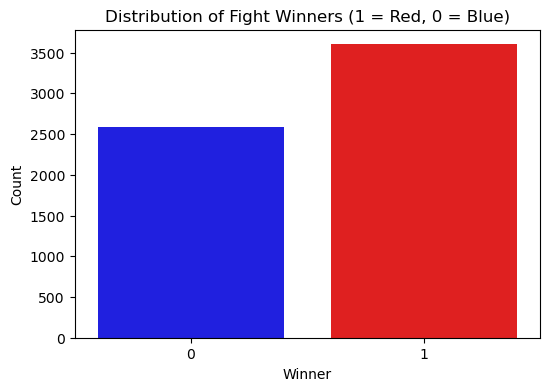

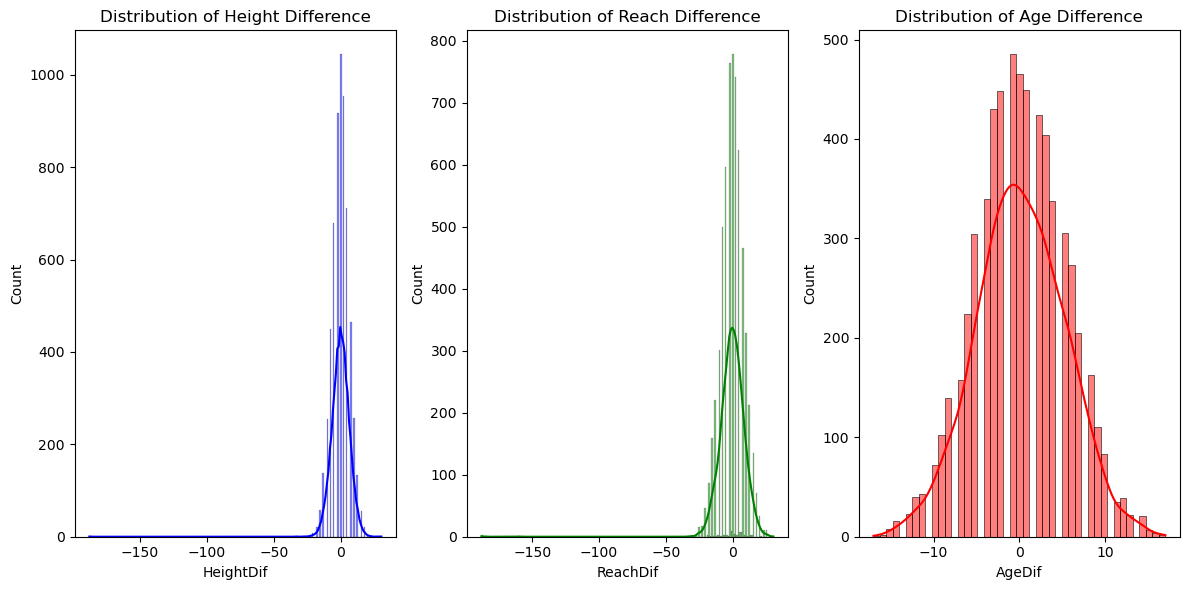

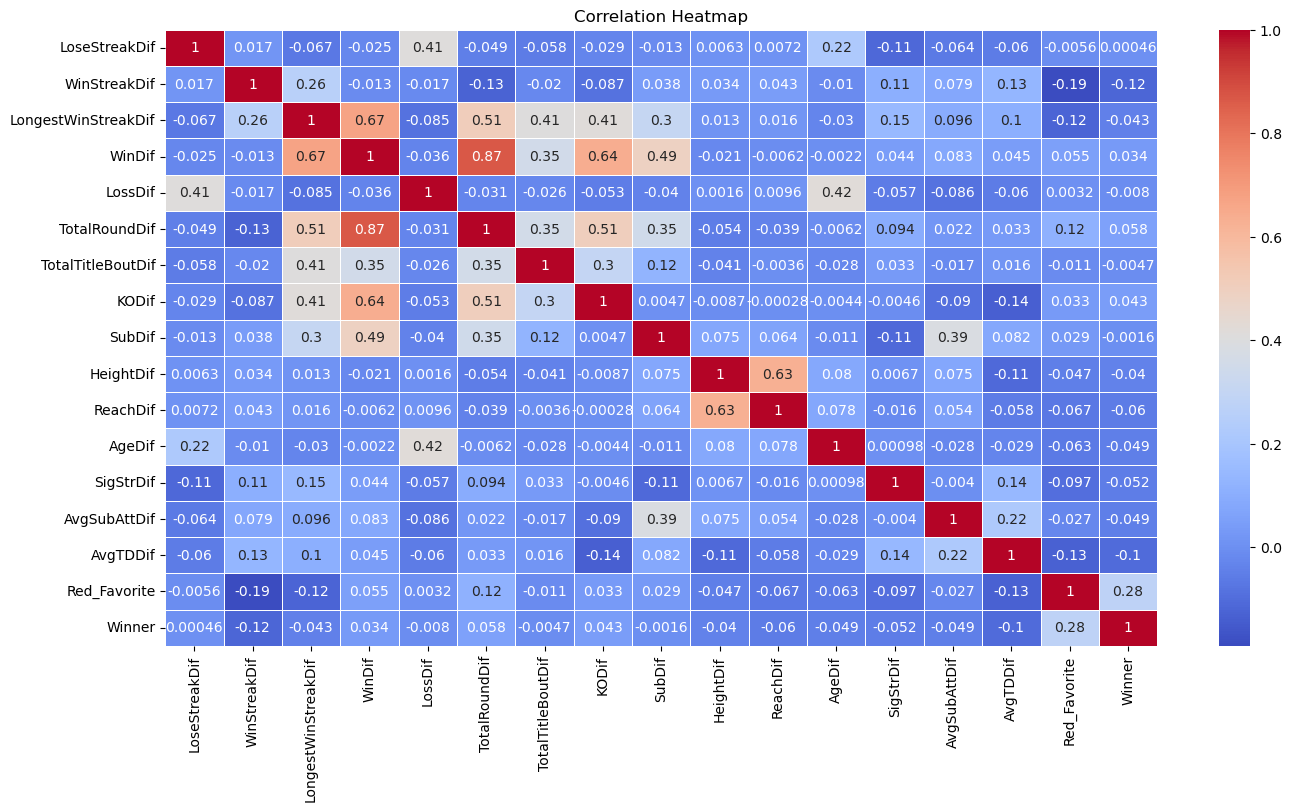

In [4]:
# Distribution of Target Variable (Winner)
# Convert Winner to binary values (1 for Red, 0 for Blue)
df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0

# Plot the distribution of winners (Red vs Blue)
plt.figure(figsize=(6, 4))
sns.countplot(x='Winner', data=df, palette=['#0000FF',"#FF0000"])
plt.title('Distribution of Fight Winners (1 = Red, 0 = Blue)')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()

# Feature Distributions
#some numerical features: HeightDif, ReachDif, AgeDif
plt.figure(figsize=(12, 6))

# Height Difference Distribution
plt.subplot(1, 3, 1)
sns.histplot(df['HeightDif'].dropna(), kde=True, color='blue')
plt.title('Distribution of Height Difference')

# Reach Difference Distribution
plt.subplot(1, 3, 2)
sns.histplot(df['ReachDif'].dropna(), kde=True, color='green')
plt.title('Distribution of Reach Difference')

# Age Difference Distribution
plt.subplot(1, 3, 3)
sns.histplot(df['AgeDif'].dropna(), kde=True, color='red')
plt.title('Distribution of Age Difference')

plt.tight_layout()
plt.show()

# Correlation Heatmap
# correlation analysis
df['Red_Favorite'] = df.apply(lambda row: (row.RedOdds < 0)&(row.BlueOdds > 0), axis = 1)
numeric_features = ['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif',
                    'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
                    'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif', 'Red_Favorite', 'Winner']

# Compute the correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Probability that the lower-ranked fighter won

In [5]:
filtered_df = df[df["BetterRank"] != "neither"]
# the number of rows with rank info
total_row_num = filtered_df.shape[0]

lower_rank_won_num = filtered_df[
    ((filtered_df["BetterRank"] == "Red") & (filtered_df["Winner"] == 0))
    | ((filtered_df["BetterRank"] == "Blue") & (filtered_df["Winner"] == 1))
].shape[0]

print("Total fights = " + str(total_row_num))
print("Lower ranked wins = " + str(lower_rank_won_num))

probability = lower_rank_won_num / total_row_num
print(f'The probability that the lower-ranked player won is: {probability}')

Total fights = 1744
Lower ranked wins = 702
The probability that the lower-ranked player won is: 0.4025229357798165


## Baseline Prediction
**Predicting the winner based solely on the betting odds**
We establish which fighter is favored to win based on the betting odds by creating a feature `red_favorite`, which is a binary catagorical variable, where `red_favorite = 1` when the red fighter is favored to win with `RedOdds` less than 0 and  `BlueOdds` greater than 0, and `red_favorite = 0` otherwise. We then form our baseline prediction by predicting that the red fighter will when if `red_favorite = 1` and that the blue fighter will win if `red_favorite = 0` for every fight input.

In [6]:
# There are only 6 draws in UFC history, so this outcome can be safely ignored. Those are not in this dataset
# Convert target variable into binary values
df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0

# Drop rows with missing values on odds
df.dropna(subset=['RedOdds', 'BlueOdds'])

# Create feature that says if Red is favorite or no

df['Red_Favorite'] = df.apply(lambda row: (row.RedOdds < 0)&(row.BlueOdds > 0), axis = 1)
df.loc[df['Red_Favorite'] == True, 'Red_Favorite'] = 1
df.loc[df['Red_Favorite'] == False, 'Red_Favorite'] = 0

# Predict that the favorite to win will win
acc = (df[((df.Red_Favorite == 1) & (df.Winner == 1))|((df.Red_Favorite == 0) & (df.Winner == 0))].shape[0])/(df.shape[0])
print("Betting on the favorite:", acc) # It's actually not too bad, we get a 65% accuracy. So, more often than not, it's a good idea to bet on the favorite

# What if we bet on the underdog?
acc = (df[((df.Red_Favorite == 1) & (df.Winner == 0))|((df.Red_Favorite == 0) & (df.Winner == 1))].shape[0])/(df.shape[0])
print("Betting on the underdog:", acc) # That is expected, it's just 1 - P(Favorite Wins)

Betting on the favorite: 0.6499595796281326
Betting on the underdog: 0.35004042037186744


/var/folders/j5/x9zgl2bn0dx9qx2gfpjlxpgm0000gn/T/ipykernel_7126/2995860537.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['Red_Favorite'] == True, 'Red_Favorite'] = 1


## Useful Features
To predict winners without using the betting odds, our primary focus is on the columns `LoseStreakDif`, `WinStreakDif`, `LongestWinStreakDif`, `WinDif`, `LossDif`, `TotalRoundDif`, `TotalTitleBoutDif`, `KODif`, `SubDif`, `HeightDif`, `ReachDif`, `AgeDif`, `SigStrDif`, `AvgSubAttDif`, and `AvgTDDif`, as these represent the most significant and apparent differences between Red and Blue fighters. It is important to note that these difference values are calculated as Blue - Red, while we assign Red = 1 and Blue = 0 when fitting the models.

In [7]:
features = ["LoseStreakDif",
            "WinStreakDif",
            "LongestWinStreakDif",
            "WinDif",
            "LossDif",
            "TotalRoundDif",
            "TotalTitleBoutDif",
            "KODif",
            "SubDif",
            "HeightDif",
            "ReachDif",
            "AgeDif",
            "SigStrDif",
            "AvgSubAttDif",
            "AvgTDDif"]
features_w_fav = features + ["Red_Favorite"]

# Predictive Models

## Model 1: Logistic Regression

### Logistic regression model using useful features:

In [8]:
y = df['Winner'] # Target
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

X = []
X = df[features]
X = pd.DataFrame(X, columns=features)

X = sm.add_constant(X) # Add constant

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Coefficients and Odds Ratios
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("-------------------\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Training Accuracy: 0.6018593371059013
Test Accuracy: 0.5949878738884398
-------------------
Feature Importance (Coefficient and Odds Ratio):
                Feature  Coefficient  Odds Ratio
0                 const     0.143763    1.154611
4                WinDif     0.021393    1.021623
1         LoseStreakDif     0.007611    1.007640
6         TotalRoundDif     0.005394    1.005409
5               LossDif     0.003192    1.003197
10            HeightDif     0.002200    1.002202
13            SigStrDif    -0.003378    0.996628
8                 KODif    -0.004869    0.995143
9                SubDif    -0.008583    0.991454
11             ReachDif    -0.012297    0.987778
7     TotalTitleBoutDif    -0.017453    0.982699
12               AgeDif    -0.021700    0.978533
14         AvgSubAttDif    -0.042400    0.958486
3   LongestWinStreakDif    -0.062787    0.939143
15             AvgTDDif    -0.095965    0.908496
2          WinStreakDif    -0.110899    0.895029


### Logistic regression model with additional features




In [9]:
# Let's try using a logistic regression with a bunch of features

y = df['Winner'] # Target
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

label_binarizer = LabelBinarizer() # Those are categorical variables

T_bout = label_binarizer.fit_transform(df['TitleBout']) # 1 Yes, 0 No
W_class = label_binarizer.fit_transform(df['WeightClass']) # Bantamweight, Catch Weight, Featherweight, Flyweight, Heavyweight, Light Heavyweight, Lightweight, Middleweight, Welterweight, Women's Bantamweight, Women's Featherweight, Women's Flyweight, Women's Strawweight
G = label_binarizer.fit_transform(df['Gender']) # 1 Male, 0 Female
R_Stance = label_binarizer.fit_transform(df['RedStance']) # Open Stance, Orthodox, Southpaw, Switch
B_stance = label_binarizer.fit_transform(df['BlueStance']) # Open Stance, Orthodox, Southpaw, Switch

X = []
X = np.append(T_bout, W_class, axis = 1)
X = np.append(X, G, axis = 1)
X = np.append(X, R_Stance, axis = 1)
X = np.append(X, B_stance, axis = 1)

X = np.append(X, df[['LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
        'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
#        ,'Red_Favorite'
        ]], axis = 1)
X = pd.DataFrame(X, columns = ['TitleBout', 'WC_Bantam', 'WC_Catch', 'WC_Feather', 'WC_Fly', 'WC_Heavy',
        'WC_LHeavy', 'WC_Light', 'WC_Middle', 'WC_Welter', 'WC_Bantam_F', 'WC_Feather_F', 'WC_Fly_F', 'WC_Straw_F',
        'Gender', 'R_Stance_Open', 'R_Stance_Ortho', 'R_Stance_South', 'R_Stance_Switch', 'B_Stance_Open', 'B_Stance_Ortho',
        'B_Stance_South', 'B_Stance_Switch', 'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif', 'TotalRoundDif',
        'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
#        ,'Red_Favorite'
        ])

X = sm.add_constant(X) # Add constant

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions and calculate accuracy
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(train_accuracy, test_accuracy) # So we do not, actually. But we get some interesting insights into what determines a winner!

# Coefficients and Odds Ratios
coefficients = log_reg.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))


0.6044866612772838 0.6014551333872271

Feature Importance (Coefficient and Odds Ratio):
                Feature  Coefficient  Odds Ratio
18       R_Stance_South     0.285631    1.330601
19      R_Stance_Switch     0.154908    1.167551
21       B_Stance_Ortho     0.145623    1.156760
2             WC_Bantam     0.135618    1.145245
4            WC_Feather     0.131415    1.140441
22       B_Stance_South     0.119920    1.127407
14           WC_Straw_F     0.099170    1.104254
6              WC_Heavy     0.096886    1.101735
17       R_Stance_Ortho     0.079796    1.083066
15               Gender     0.046834    1.047948
8              WC_Light     0.038871    1.039637
23      B_Stance_Switch     0.029558    1.029999
27               WinDif     0.024532    1.024835
24        LoseStreakDif     0.006541    1.006563
29        TotalRoundDif     0.005272    1.005286
28              LossDif     0.003817    1.003824
33            HeightDif     0.001910    1.001912
3              WC_Catch    -0.

## Model 2: Decision Tree

### Unpruned & Pruned Trees

Unpruned Tree - Training Accuracy: 0.9993936944219887
Unpruned Tree - Test Accuracy: 0.5392077607113985


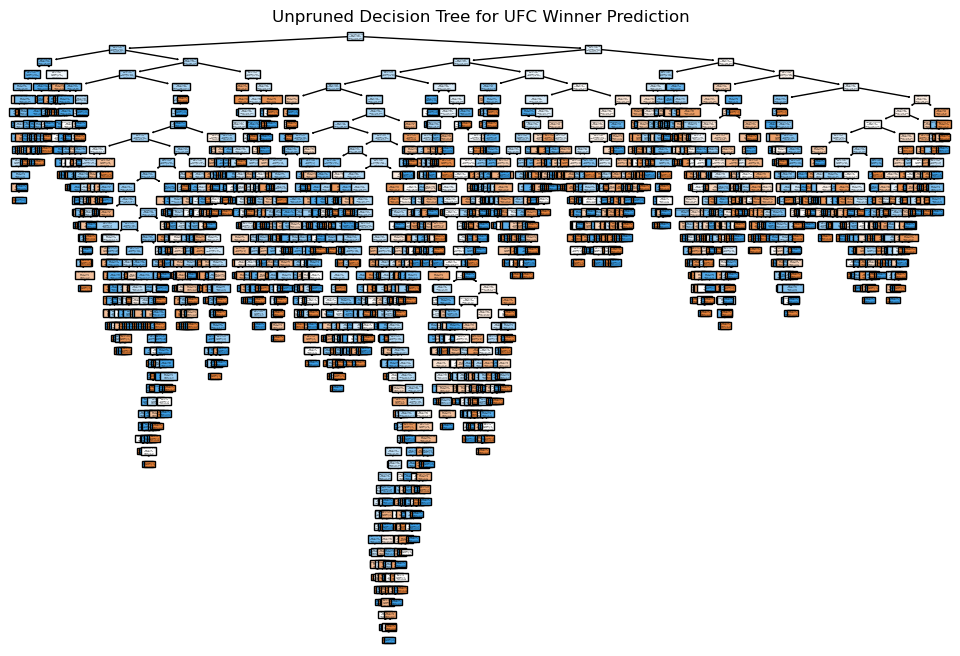

Best ccp_alpha: 0.0012929596448898184
Pruned Tree - Training Accuracy: 0.6097413096200485
Pruned Tree - Test Accuracy: 0.5893290218270008


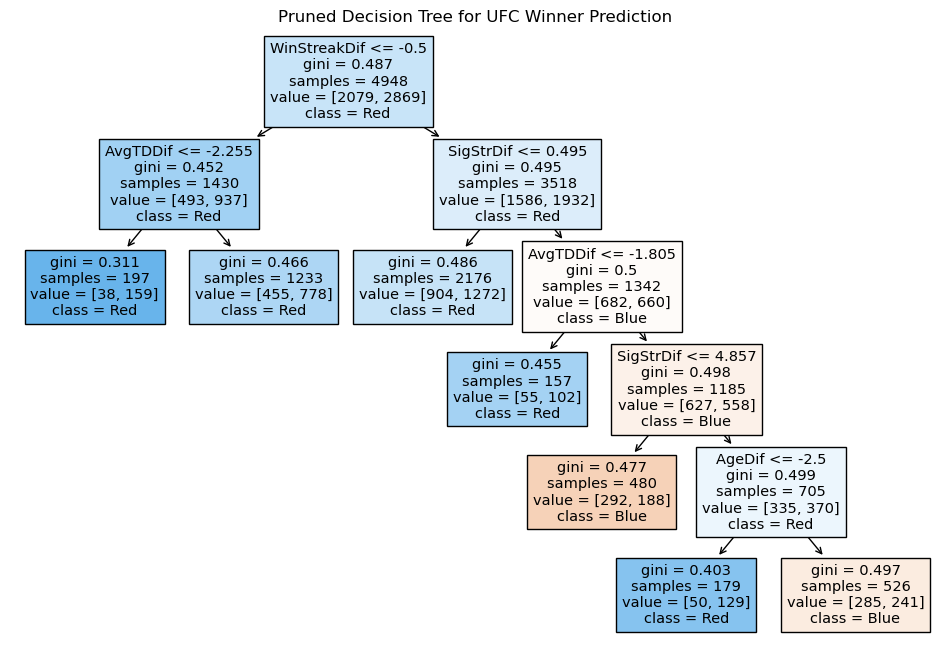

In [10]:
df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0
df['Winner'] = pd.to_numeric(df['Winner'])

X = df[features]
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Unpruned Tree ###
# Train the unpruned decision tree
unpruned_clf = DecisionTreeClassifier(random_state=13)
unpruned_clf.fit(X_train, y_train)

y_train_pred_unpruned = unpruned_clf.predict(X_train)
y_test_pred_unpruned = unpruned_clf.predict(X_test)

train_accuracy_unpruned = accuracy_score(
    y_train, y_train_pred_unpruned
)  # obviously overfit the data
test_accuracy_unpruned = accuracy_score(y_test, y_test_pred_unpruned)

print(f'Unpruned Tree - Training Accuracy: {train_accuracy_unpruned}')
print(f'Unpruned Tree - Test Accuracy: {test_accuracy_unpruned}')

# Plot the unpruned tree
plt.figure(figsize=(12, 8))
plot_tree(unpruned_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Unpruned Decision Tree for UFC Winner Prediction')
plt.show()


### Pruned Tree (Cost Complexity Pruning) ###

# Compute the pruning path to get possible ccp_alpha values
clf = DecisionTreeClassifier(random_state=13)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a tree for each ccp_alpha and use cross-validation to find the best alpha
clfs = []
cv_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha)
    # Perform 5-fold cross-validation to determine the best ccp_alpha
    scores = cross_val_score(
        clf, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
    )
    clfs.append(clf)
    cv_scores.append(np.mean(scores))

# Select the best ccp_alpha based on the cross-validation scores
best_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_index]
best_clf = clfs[best_index]

print(f'Best ccp_alpha: {best_ccp_alpha}')

# Train the final model with the best ccp_alpha on the entire training set
best_clf.fit(X_train, y_train)

y_train_pred_pruned = best_clf.predict(X_train)
y_test_pred_pruned = best_clf.predict(X_test)

train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f'Pruned Tree - Training Accuracy: {train_accuracy_pruned}')
print(f'Pruned Tree - Test Accuracy: {test_accuracy_pruned}')

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=features, class_names=['Blue', 'Red'], filled=True)
plt.title('Pruned Decision Tree for UFC Winner Prediction')
plt.show()

### Unpruned & Pruned Trees with `Red_Favorite`

Unpruned Tree - Training Accuracy: 0.9997978981406629
Unpruned Tree - Test Accuracy: 0.5650767987065481


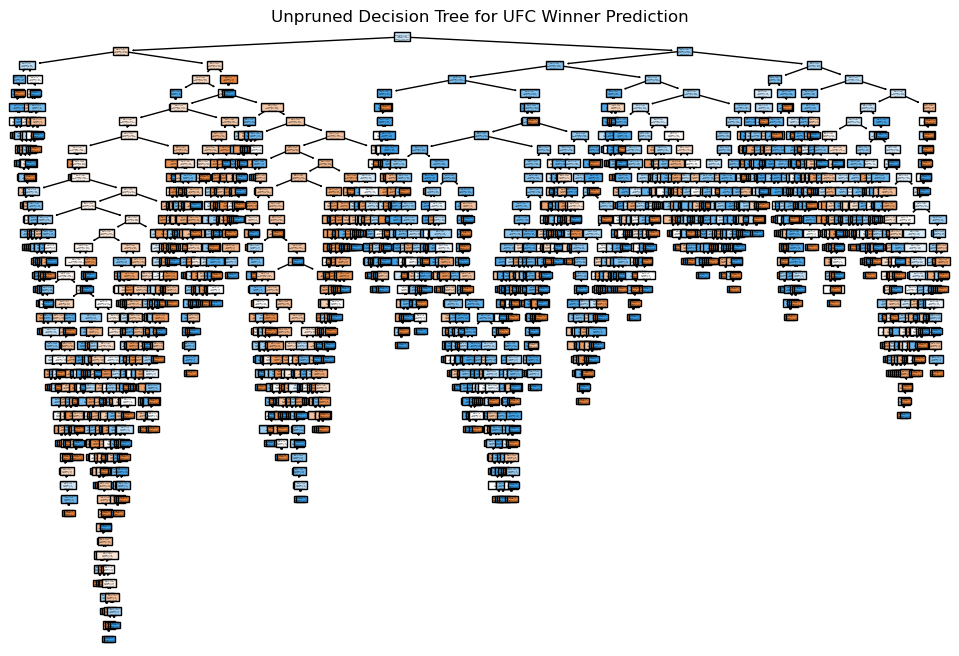

Best ccp_alpha: 0.0019747377877403216
Pruned Tree - Training Accuracy: 0.6503637833468068
Pruned Tree - Test Accuracy: 0.6483427647534358


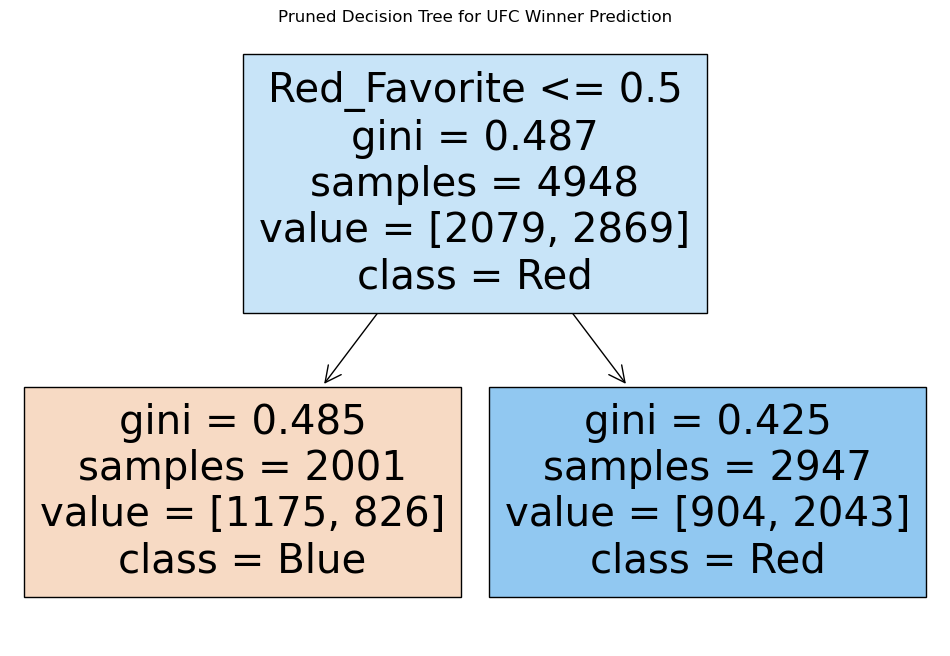

In [11]:
df.loc[df['Winner'] == "Red", 'Winner'] = 1
df.loc[df['Winner'] == "Blue", 'Winner'] = 0
df['Winner'] = pd.to_numeric(df['Winner'])

X = df[features_w_fav]
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Unpruned Tree ###

# Train the unpruned decision tree
unpruned_clf = DecisionTreeClassifier(random_state=13)
unpruned_clf.fit(X_train, y_train)

y_train_pred_unpruned = unpruned_clf.predict(X_train)
y_test_pred_unpruned = unpruned_clf.predict(X_test)

train_accuracy_unpruned = accuracy_score(
    y_train, y_train_pred_unpruned
)  # obviously overfit the data
test_accuracy_unpruned = accuracy_score(y_test, y_test_pred_unpruned)

print(f'Unpruned Tree - Training Accuracy: {train_accuracy_unpruned}')
print(f'Unpruned Tree - Test Accuracy: {test_accuracy_unpruned}')

# Plot the unpruned tree
plt.figure(figsize=(12, 8))
plot_tree(unpruned_clf, feature_names=features_w_fav, class_names=['Blue', 'Red'], filled=True)
plt.title('Unpruned Decision Tree for UFC Winner Prediction')
plt.show()


### Pruned Tree (Cost Complexity Pruning) ###

# Compute the pruning path to get possible ccp_alpha values
clf = DecisionTreeClassifier(random_state=13)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a tree for each ccp_alpha and use cross-validation to find the best alpha
clfs = []
cv_scores = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha)
    # Perform 5-fold cross-validation to determine the best ccp_alpha
    scores = cross_val_score(
        clf, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
    )
    clfs.append(clf)
    cv_scores.append(np.mean(scores))

# Select the best ccp_alpha based on the cross-validation scores
best_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_index]
best_clf = clfs[best_index]

print(f'Best ccp_alpha: {best_ccp_alpha}')

# Train the final model with the best ccp_alpha on the entire training set
best_clf.fit(X_train, y_train)

y_train_pred_pruned = best_clf.predict(X_train)
y_test_pred_pruned = best_clf.predict(X_test)

train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f'Pruned Tree - Training Accuracy: {train_accuracy_pruned}')
print(f'Pruned Tree - Test Accuracy: {test_accuracy_pruned}')

# Plot the pruned decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_clf, feature_names=features_w_fav, class_names=['Blue', 'Red'], filled=True)
plt.title('Pruned Decision Tree for UFC Winner Prediction')
plt.show()

### Decision Tree using `WeightClass`, `RedStance`, and `BlueStance`

Unpruned Tree - Training Accuracy: 0.5909458367016976
Unpruned Tree - Test Accuracy: 0.5739692805173807


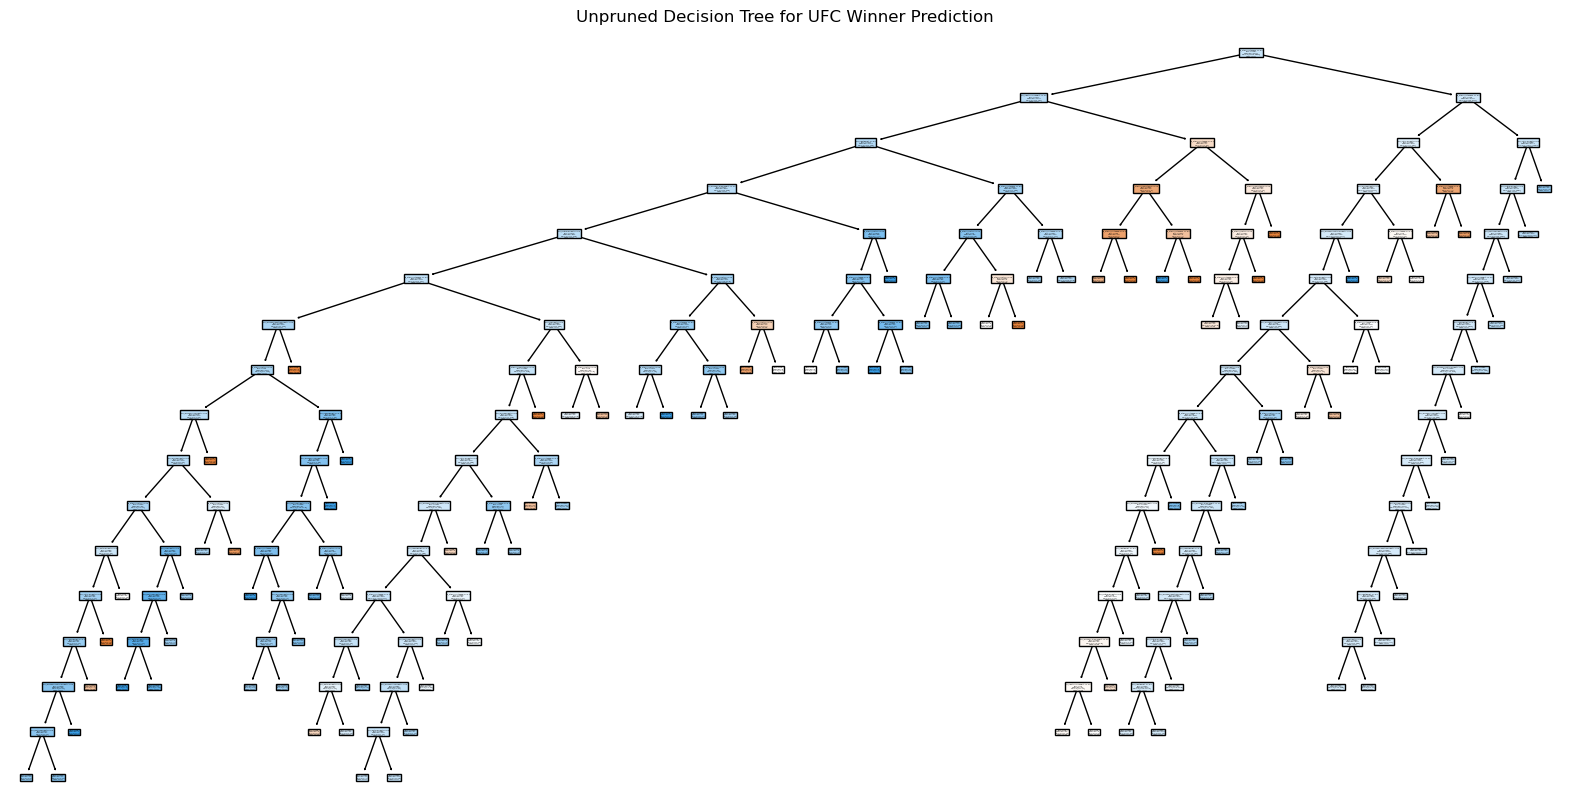

Best ccp_alpha: 0.00033912079797979167
Cross-validated accuracy with best ccp_alpha: 0.5790244201366548
Pruned Tree - Training Accuracy: 0.5824575586095392
Pruned Tree - Test Accuracy: 0.587712206952304


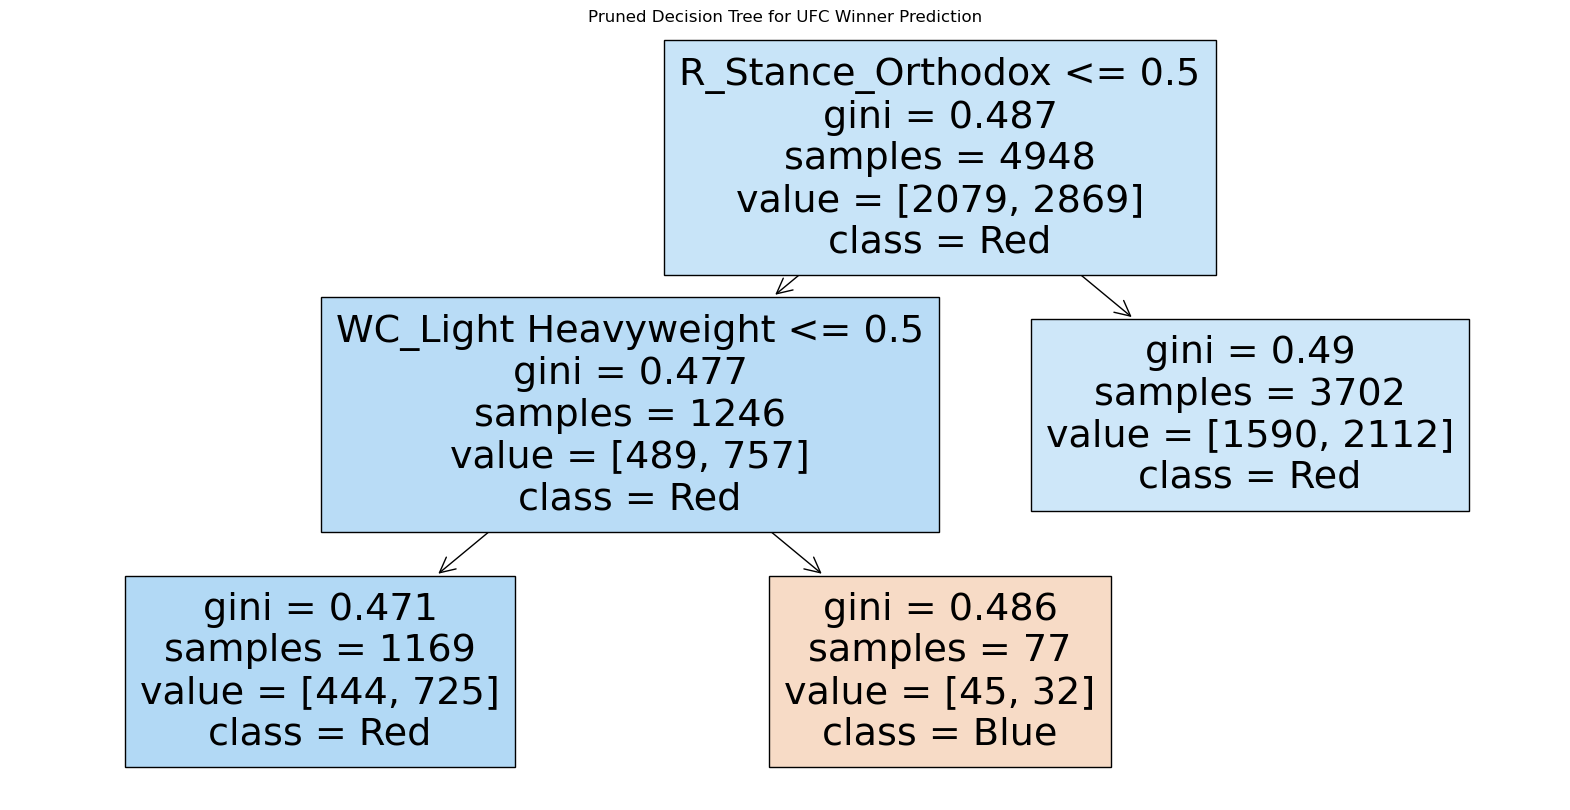

In [13]:
# Separate LabelBinarizer instances for each categorical variable
lb_weight = LabelBinarizer()
lb_red_stance = LabelBinarizer()
lb_blue_stance = LabelBinarizer()

W_class = lb_weight.fit_transform(df["WeightClass"])
W_class_labels = lb_weight.classes_
W_class_columns = [f"WC_{cls}" for cls in W_class_labels]

R_Stance = lb_red_stance.fit_transform(df["RedStance"])
R_stance_labels = lb_red_stance.classes_
R_stance_columns = [f"R_Stance_{cls}" for cls in R_stance_labels]

B_Stance = lb_blue_stance.fit_transform(df["BlueStance"])
B_stance_labels = lb_blue_stance.classes_
B_stance_columns = [f"B_Stance_{cls}" for cls in B_stance_labels]

X = np.concatenate((W_class, R_Stance, B_Stance), axis=1)
feature_names = W_class_columns + R_stance_columns + B_stance_columns

X = pd.DataFrame(X, columns=feature_names)
y = df["Winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

### Unpruned Tree ###

# Train the unpruned decision tree
unpruned_clf = DecisionTreeClassifier(random_state=13)
unpruned_clf.fit(X_train, y_train)

y_train_pred_unpruned = unpruned_clf.predict(X_train)
y_test_pred_unpruned = unpruned_clf.predict(X_test)

# Obviously overfit the data
train_accuracy_unpruned = accuracy_score(y_train, y_train_pred_unpruned)
test_accuracy_unpruned = accuracy_score(y_test, y_test_pred_unpruned)

print(f"Unpruned Tree - Training Accuracy: {train_accuracy_unpruned}")
print(f"Unpruned Tree - Test Accuracy: {test_accuracy_unpruned}")

# Plot the unpruned tree
plt.figure(figsize=(20, 10))
plot_tree(
    unpruned_clf, feature_names=feature_names, class_names=["Blue", "Red"], filled=True
)
plt.title("Unpruned Decision Tree for UFC Winner Prediction")
plt.show()

### Pruned Tree (Cost Complexity Pruning) ###

# Compute the pruning path to get possible ccp_alpha values
clf = DecisionTreeClassifier(random_state=13)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Remove the maximum value of alpha (as it would prune all leaves)
ccp_alphas = ccp_alphas[:-1]

clfs = []
cv_means = []
cv_stds = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha)
    # Perform 5-fold cross-validation to determine the best ccp_alpha
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    clfs.append(clf)
    cv_means.append(scores.mean())
    cv_stds.append(scores.std())

# Find the optimal ccp_alpha
max_mean = max(cv_means)
optimal_alpha_indices = [
    i for i, mean in enumerate(cv_means) if mean >= max_mean - cv_stds[i]
]
best_alpha_index = optimal_alpha_indices[
    -1
]  # Choose the largest alpha for simpler tree
best_ccp_alpha = ccp_alphas[best_alpha_index]

# Train the final model with the best ccp_alpha on the entire training set
best_clf = DecisionTreeClassifier(random_state=13, ccp_alpha=best_ccp_alpha)
best_clf.fit(X_train, y_train)

print(f"Best ccp_alpha: {best_ccp_alpha}")
print(f"Cross-validated accuracy with best ccp_alpha: {cv_means[best_alpha_index]}")

y_train_pred_pruned = best_clf.predict(X_train)
y_test_pred_pruned = best_clf.predict(X_test)

train_accuracy_pruned = accuracy_score(y_train, y_train_pred_pruned)
test_accuracy_pruned = accuracy_score(y_test, y_test_pred_pruned)

print(f"Pruned Tree - Training Accuracy: {train_accuracy_pruned}")
print(f"Pruned Tree - Test Accuracy: {test_accuracy_pruned}")

# Plot the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf, feature_names=feature_names, class_names=["Blue", "Red"], filled=True
)
plt.title("Pruned Decision Tree for UFC Winner Prediction")
plt.show()

## Model 3: Multilayer Perceptron Model

In [14]:
from sklearn.neural_network import MLPClassifier

# Define the feature columns and the target column
X = df[features]
y = df['Winner']

# test/train split, using the same random seed as the decision tree model for comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

mlp = MLPClassifier(max_iter=500, random_state=13, batch_size = 250)

# cross validation to determine best parameters
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (150,)],
    'alpha': [0.0001, 0.001, 0.01],
}
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
mlp.set_params(**grid_search.best_params_)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

{'alpha': 0.0001, 'hidden_layer_sizes': (20,)}
Accuracy: 0.5925626515763945


## Model 4: Random Forest

Best Parameters found by GridSearchCV:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 50}

Random Forest - Training Accuracy: 0.6491511721907841
Random Forest - Test Accuracy: 0.5860953920776071


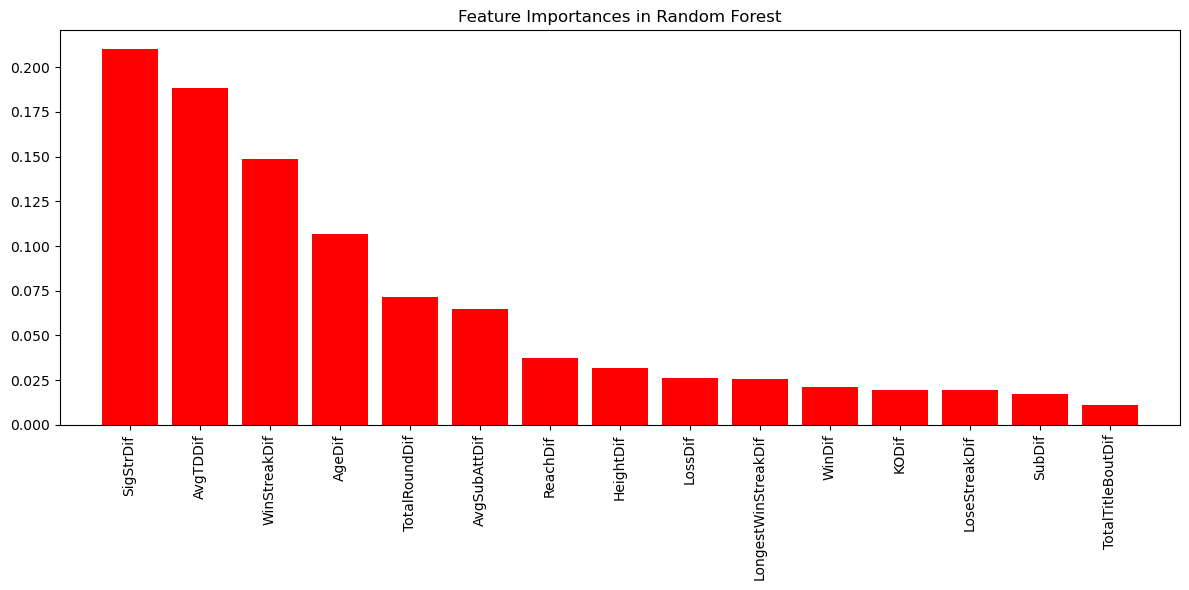

In [15]:
from sklearn.ensemble import RandomForestClassifier

X = df[features]
y = df["Winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

### Random Forest with Cross-Validation ###

param_grid = {
    "n_estimators": [3, 10, 50, 100],  # Number of trees in the forest.
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
}

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=13)

grid_search = GridSearchCV(
    estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy"
)

grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf_clf = grid_search.best_estimator_

y_train_pred_rf = best_rf_clf.predict(X_train)
y_test_pred_rf = best_rf_clf.predict(X_test)

# Calculate accuracies
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"\nRandom Forest - Training Accuracy: {train_accuracy_rf}")
print(f"Random Forest - Test Accuracy: {test_accuracy_rf}")

# Plot feature importances
# calculated based on the impurity reduction achieved by splitting on a feature.
# The impurity reduction comes from using metrics like the Gini Index or Entropy to measure how well a feature splits the data into homogeneous groups
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(len(features)), importances[indices], color="r", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlim([-1, len(features)])
plt.tight_layout()
plt.show()

### Random forest with `WeightClass`, `RedStance`, and `BlueStance`

Best Parameters found by GridSearchCV:
{'max_depth': 5, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest - Training Accuracy: 0.5854890864995957
Random Forest - Test Accuracy: 0.5909458367016976


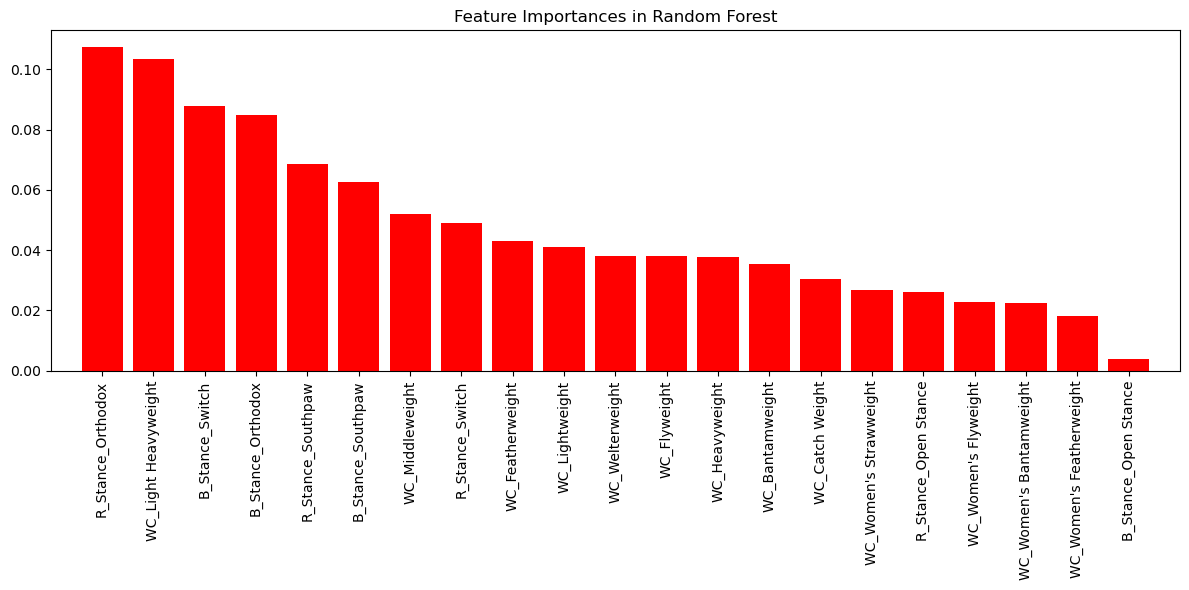

In [16]:
# Separate LabelBinarizer instances for each categorical variable
lb_weight = LabelBinarizer()
lb_red_stance = LabelBinarizer()
lb_blue_stance = LabelBinarizer()

W_class = lb_weight.fit_transform(df["WeightClass"])
W_class_labels = lb_weight.classes_
W_class_columns = [f"WC_{cls}" for cls in W_class_labels]

R_Stance = lb_red_stance.fit_transform(df["RedStance"])
R_stance_labels = lb_red_stance.classes_
R_stance_columns = [f"R_Stance_{cls}" for cls in R_stance_labels]

B_Stance = lb_blue_stance.fit_transform(df["BlueStance"])
B_stance_labels = lb_blue_stance.classes_
B_stance_columns = [f"B_Stance_{cls}" for cls in B_stance_labels]

X = np.concatenate((W_class, R_Stance, B_Stance), axis=1)
feature_names = W_class_columns + R_stance_columns + B_stance_columns

X = pd.DataFrame(X, columns=feature_names)
y = df["Winner"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

### Random Forest with Cross-Validation ###

param_grid = {
    "n_estimators": [3, 10, 50, 100],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
}

rf_clf = RandomForestClassifier(random_state=13)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy"
)

# Fit the model to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf_clf = grid_search.best_estimator_

# Make predictions with the best estimator
y_train_pred_rf = best_rf_clf.predict(X_train)
y_test_pred_rf = best_rf_clf.predict(X_test)

# Calculate accuracies
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"\nRandom Forest - Training Accuracy: {train_accuracy_rf}")
print(f"Random Forest - Test Accuracy: {test_accuracy_rf}")

# Plot feature importances
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = feature_names

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(len(features)), importances[indices], color="r", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlim([-1, len(features)])
plt.tight_layout()
plt.show()

## Model 5: XGBoost

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
features = ['RedStance', 'BlueStance', 'WeightClass', 'TitleBout',
            'LoseStreakDif', 'WinStreakDif', 'LongestWinStreakDif', 'WinDif',
            'LossDif', 'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif',
            'HeightDif', 'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif'
#            ,"Red_Favorite"
            ]
df_encoded = pd.get_dummies(df, columns=['RedStance', 'BlueStance', 'WeightClass', 'TitleBout'
#                                         ,"Red_Favorite"
                                         ], drop_first=True)

# Re-check the updated feature names after encoding to select correctly
encoded_features = [col for col in df_encoded.columns if any(f in col for f in features)]

X = df_encoded[encoded_features]
y = df_encoded['Winner']  # Encoding 'Red' as 1 and 'Blue' as 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

0.5642683912691997
              precision    recall  f1-score   support

           0       0.46      0.38      0.42       505
           1       0.62      0.69      0.65       732

    accuracy                           0.56      1237
   macro avg       0.54      0.54      0.53      1237
weighted avg       0.55      0.56      0.56      1237



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:50:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1, np.sum(y == 0) / np.sum(y == 1)],  # Set to balance classes if needed
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring='accuracy',
    n_iter=50,
    cv=skf,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best model based on the random search
best_xgb_model = random_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC calculation

test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test ROC-AUC: {test_roc_auc}")
print("\nClassification Report on Test Set:")
print(classification_report_output)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:50:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:50:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:50:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:50:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:

Best Parameters: {'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Test Accuracy: 0.6095392077607114
Test ROC-AUC: 0.602410322999513

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.56      0.20      0.29       505
           1       0.62      0.89      0.73       732

    accuracy                           0.61      1237
   macro avg       0.59      0.55      0.51      1237
weighted avg       0.59      0.61      0.55      1237



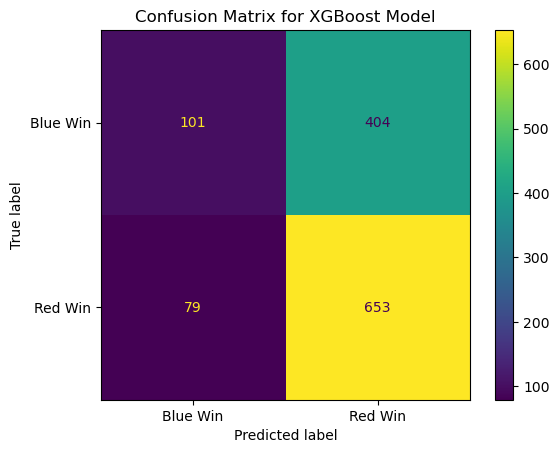

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test, display_labels=['Blue Win', 'Red Win'])
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

One factor that was noticed before utilizing pruning was the severe problem of overfitting. As shown previously, the decision tree achieved a training accuracy of approximately 99%, but a testing accuracy of only 53%. Hence, a way to bypass this is through XGBoost, as it includes regularization parameters to prevent overfitting, and combines multiple decision trees using boosting, which improves accuracy by reducing errors and overfitting.

Through a Randomized Search Cross Validation, parameters were optimized, and finally achieved a higher testing accuracy than the previously implemented Decision Tree.

In [22]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



random_search.fit(X_train, y_train)
best_xgb_model = random_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC calculation

test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test ROC-AUC: {test_roc_auc}")
print("\nClassification Report on Test Set:")
print(classification_report_output)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:51:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:51:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:51:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:51:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:

Best Parameters: {'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Test Accuracy: 0.6095392077607114
Test ROC-AUC: 0.602410322999513

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.56      0.20      0.29       505
           1       0.62      0.89      0.73       732

    accuracy                           0.61      1237
   macro avg       0.59      0.55      0.51      1237
weighted avg       0.59      0.61      0.55      1237

